In [ ]:
# instalamos shap con el siguiente comando:
!pip install shap

Dataset cargado correctamente.
Primeras filas del dataset:
   customerID  tenure PhoneService        Contract PaperlessBilling  \
0  7590-VHVEG       1           No  Month-to-month              Yes   
1  5575-GNVDE      34          Yes        One year               No   
2  3668-QPYBK       2          Yes  Month-to-month              Yes   
3  7795-CFOCW      45           No        One year               No   
4  9237-HQITU       2          Yes  Month-to-month              Yes   

               PaymentMethod  MonthlyCharges TotalCharges Churn  
0           Electronic check           29.85        29.85    No  
1               Mailed check           56.95       1889.5    No  
2               Mailed check           53.85       108.15   Yes  
3  Bank transfer (automatic)           42.30      1840.75    No  
4           Electronic check           70.70       151.65   Yes  

Información del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (tota

<Figure size 640x480 with 0 Axes>

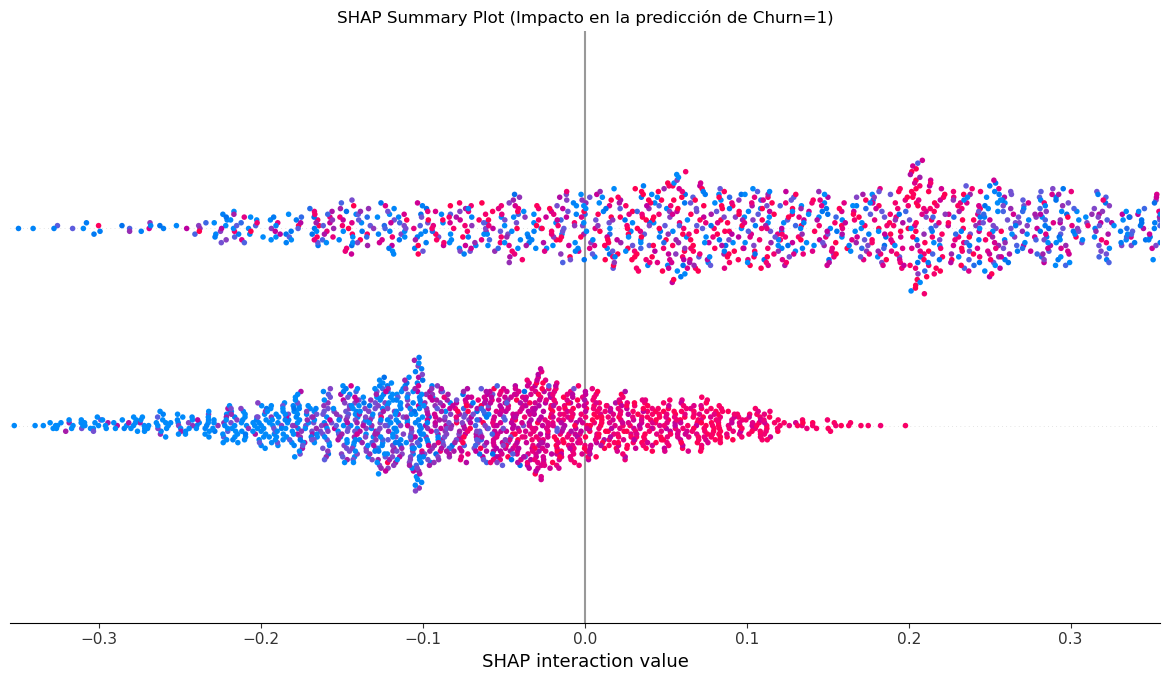

Mostrando Gráfico Resumen (barras)...


<Figure size 640x480 with 0 Axes>

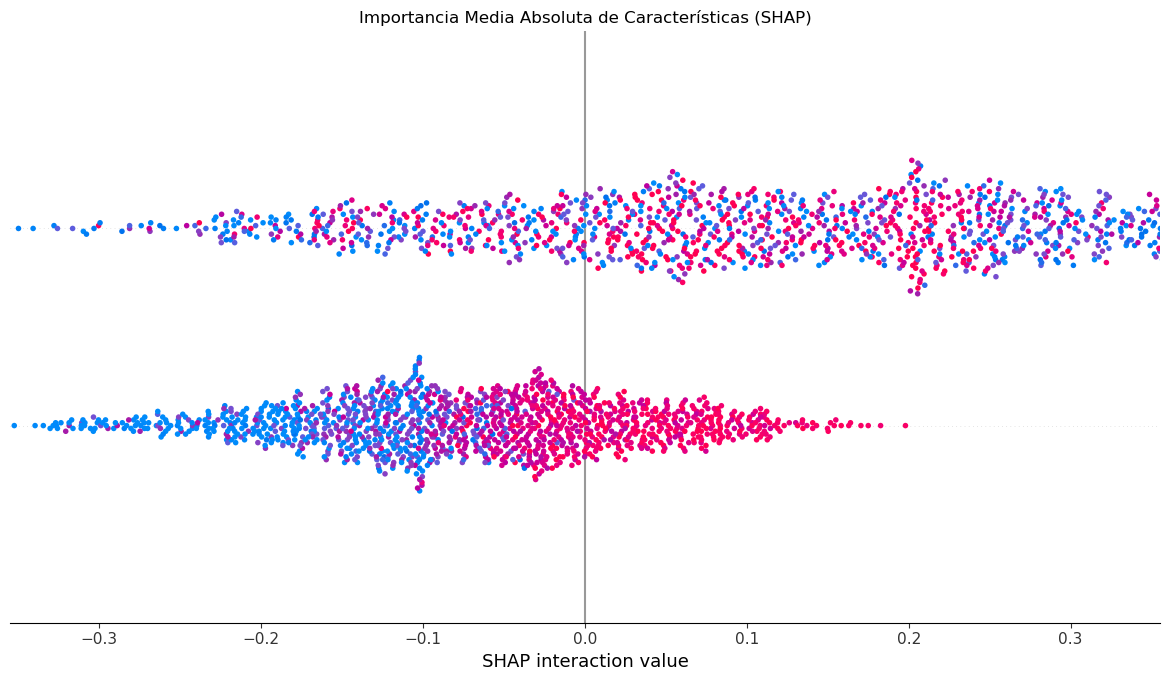

Error al generar el gráfico de dependencia: Data must be 1-dimensional, got ndarray of shape (10, 2) instead

Generando explicación SHAP para la instancia 0 del conjunto de prueba...
Objeto shap.Explanation creado.

Mostrando Gráfico de Fuerza para la instancia 0, Clase 1 (Churn)...

Análisis de interpretabilidad con SHAP completado.


In [19]:
import pandas as pd
import shap
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

#Cargar y Preparar los Datos

# Cargar el dataset
try:
    df = pd.read_csv('churn_data.csv')
    print("Dataset cargado correctamente.")
    print("Primeras filas del dataset:")
    print(df.head())
    print("\nInformación del dataset:")
    df.info()
except FileNotFoundError:
    print("Error: No se encontró el archivo 'churn_data.csv'.")
    # Salir si el archivo no se encuentra
    exit()
except Exception as e:
    print(f"Ocurrió un error al cargar el archivo: {e}")
    exit()

# Identificar la variable objetivo (asumiendo que es 'Churn')
target_column = 'Churn'
if target_column not in df.columns:
    print(f"Error: La columna '{target_column}' no se encuentra en el dataset.")
    # Intenta adivinar o pide al usuario
    print("Columnas disponibles:", df.columns.tolist())
    # Por ahora, saldremos si no encontramos 'Churn'
    exit()

# Preprocesamiento básico
# Eliminar columnas no informativas (si las hay, como IDs de cliente)
# Asumiendo que 'customerID' no es útil para la predicción
if 'customerID' in df.columns:
    df = df.drop('customerID', axis=1)

# Convertir 'TotalCharges' a numérico, manejando errores (espacios vacíos)
if 'TotalCharges' in df.columns:
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
    # Rellenar valores nulos creados (por ejemplo, con la mediana)
    if df['TotalCharges'].isnull().sum() > 0:
        median_val = df['TotalCharges'].median()
        df['TotalCharges'] = df['TotalCharges'].fillna(median_val)
        print(f"\nValores nulos en 'TotalCharges' rellenados con la mediana ({median_val}).")

# Identificar características categóricas y numéricas
categorical_features = df.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Asegurarse de que la columna objetivo no esté en las listas de características
if target_column in categorical_features:
    categorical_features.remove(target_column)
if target_column in numerical_features:
    numerical_features.remove(target_column)

print(f"\nCaracterísticas Categóricas: {categorical_features}")
print(f"Características Numéricas: {numerical_features}")
print(f"Variable Objetivo: {target_column}")

# Codificar variables categóricas (usando One-Hot Encoding)
df_processed = pd.get_dummies(df, columns=categorical_features, drop_first=True)

# Codificar la variable objetivo si es categórica (ej. 'Yes'/'No' a 1/0)
if df_processed[target_column].dtype == 'object':
    le = LabelEncoder()
    df_processed[target_column] = le.fit_transform(df_processed[target_column])
    print(f"\nVariable objetivo '{target_column}' codificada: {le.classes_} -> {le.transform(le.classes_)}")


# Separar características (X) y objetivo (y)
X = df_processed.drop(target_column, axis=1)
y = df_processed[target_column]

print("\nDimensiones de X (características procesadas):", X.shape)
print("Dimensiones de y (objetivo):", y.shape)

# --- 2. Dividir los Datos ---

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTamaño del conjunto de entrenamiento: {X_train.shape[0]} instancias")
print(f"Tamaño del conjunto de prueba: {X_test.shape[0]} instancias")

# --- 3. Entrenar un Modelo ---

# Usaremos RandomForestClassifier como ejemplo
model = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
print("\nEntrenando el modelo RandomForestClassifier...")
model.fit(X_train, y_train)
print("Modelo entrenado.")

# Evaluar el rendimiento (opcional, pero bueno para tener contexto)
accuracy = model.score(X_test, y_test)
print(f"Accuracy del modelo en el conjunto de prueba: {accuracy:.4f}")

# --- 4. Calcular Valores SHAP ---

print("\nCalculando los valores SHAP...")
# Usamos TreeExplainer porque RandomForest es un modelo basado en árboles
explainer = shap.TreeExplainer(model)

# Calculamos los valores SHAP para el conjunto de prueba
# Puede tardar un poco si el conjunto de prueba es grande
shap_values = explainer.shap_values(X_test)
print("Valores SHAP calculados.")

# `shap_values` para clasificación binaria suele ser una lista con dos arrays:
# uno para la clase 0 y otro para la clase 1.
# Generalmente, nos interesa interpretar la contribución hacia la clase positiva (clase 1).
# Si `shap_values` es una lista de longitud 2, tomamos el segundo elemento.
if isinstance(shap_values, list) and len(shap_values) == 2:
    shap_values_positive_class = shap_values[1]
    print("Se usarán los valores SHAP para la clase positiva (1).")
else:
    # Si el modelo devuelve directamente los SHAP para la clase positiva o es regresión
    shap_values_positive_class = shap_values


# --- 5. Visualizar e Interpretar ---

print("\nGenerando visualizaciones SHAP...")

# a) Gráfico Resumen (Summary Plot) - Importancia global y dirección del efecto
# Muestra las características más importantes y cómo sus valores afectan la predicción.
# Cada punto es una instancia, el color indica el valor de la característica (alto/bajo).
print("Mostrando Gráfico Resumen (beeswarm)...")
shap.summary_plot(shap_values_positive_class, X_test, plot_type="beeswarm", show=False)
plt.title("SHAP Summary Plot (Impacto en la predicción de Churn=1)")
plt.show()

# También se puede mostrar como gráfico de barras (importancia media absoluta)
print("Mostrando Gráfico Resumen (barras)...")
shap.summary_plot(shap_values_positive_class, X_test, plot_type="bar", show=False)
plt.title("Importancia Media Absoluta de Características (SHAP)")
plt.show()


# b) Gráfico de Dependencia (Dependence Plot) - Efecto de una característica específica
# Elige una característica importante (p.ej., la primera del summary plot)
# Puede requerir instalar matplotlib si no está instalado
try:
    # Calcular la importancia media absoluta para ordenar
    mean_abs_shap = pd.Series(abs(shap_values_positive_class).mean(axis=0), index=X_test.columns)
    most_important_feature = mean_abs_shap.sort_values(ascending=False).index[0]

    print(f"\nMostrando Gráfico de Dependencia para la característica más importante: '{most_important_feature}'...")
    shap.dependence_plot(most_important_feature, shap_values_positive_class, X_test, interaction_index="auto", show=False)
    # plt.title(f"SHAP Dependence Plot: {most_important_feature}") # El título se pone automáticamente
    plt.show()
except ImportError:
     print("Matplotlib no está instalado. No se puede mostrar el gráfico de dependencia.")
except Exception as e:
     print(f"Error al generar el gráfico de dependencia: {e}")

#en esta linea tuve bastante problema, me daba muchos errores por muchos motivos, al final se tuvo utilizar try/except para
#poder identificar el error, obteniendo resultado negativo
# c) Gráfico de Fuerza (Force Plot) - Explicación de una predicción individual
instance_index_to_explain = 0 # Explicar la primera instancia del conjunto de prueba
print(f"\nGenerando explicación SHAP para la instancia {instance_index_to_explain} del conjunto de prueba...")

# 1. Seleccionar la instancia (como DataFrame 2D)
instance_features = X_test.iloc[[instance_index_to_explain]]

# 2. Calcular SHAP values específicamente para esta instancia
#    La estructura exacta de salida puede variar, pero Explanation lo manejará.
shap_values_instance = explainer.shap_values(instance_features)

# 3. Crear el objeto shap.Explanation directamente
#    Pasamos los SHAP values tal como los devuelve explainer y los base_values completos.
try:
    explanation_instance = shap.Explanation(
        values=shap_values_instance,          # Salida directa de shap_values
        base_values=explainer.expected_value, # Base values para todas las clases
        data=instance_features,                # Feature values (DataFrame shape 1, n_features)
        feature_names=X_test.columns.tolist()  # Nombres de las características
    )
    print("Objeto shap.Explanation creado.")
    # Nota: La estructura interna de 'explanation_instance' puede ser (num_samples, num_features, num_classes)
    # o una lista si el explainer devuelve lista.

    print(f"\nMostrando Gráfico de Fuerza para la instancia {instance_index_to_explain}, Clase 1 (Churn)...")

    # 4. Generar el force_plot especificando la clase/output de interés (índice 1 para Churn=1)
    #    Accedemos a la primera muestra [0] y al segundo output/clase [:,:,1] o similar.
    #    La sintaxis exacta puede depender de la estructura interna, probemos con exp[0,:,1]
    #    Si da error, podría ser exp[0].values[:,1] o similar.

    # Intentemos acceder a la muestra 0, todas las features, output/clase 1
    shap.force_plot(explanation_instance[0,:,1], # Explicación para muestra 0, clase 1
                    show=False)

    # plt.title(f"SHAP Force Plot para la Instancia {instance_index_to_explain} (Predicción Churn=1)") # Opcional
    plt.show() # Mostrar la gráfica

except Exception as e:
    print(f"\nError al crear/usar shap.Explanation o force_plot: {e}")
    print("--- Información de depuración ---")
    print("Tipo de shap_values_instance:", type(shap_values_instance))
    if isinstance(shap_values_instance, list):
        print("Longitud de shap_values_instance:", len(shap_values_instance))
        if len(shap_values_instance) > 0:
            print("Shape del primer elemento:", shap_values_instance[0].shape)
    elif hasattr(shap_values_instance, 'shape'):
        print("Shape de shap_values_instance:", shap_values_instance.shape)
    print("Tipo de explainer.expected_value:", type(explainer.expected_value))
    if hasattr(explainer.expected_value, 'shape'):
        print("Shape de explainer.expected_value:", explainer.expected_value.shape)
    else:
        print("Valor de explainer.expected_value:", explainer.expected_value)
    print("-------------------------------")


print("\nAnálisis de interpretabilidad con SHAP completado.")

1. Características de Mayor Impacto y su Influencia:

   - Identificación: El shap.summary_plot (tanto en formato de barras como "beeswarm") te mostraría qué características está usando más tu modelo para tomar decisiones. Las características con mayores valores SHAP promedio (en valor absoluto, gráfico de barras) son las más influyentes globalmente.
     
      - Ejemplo típico en Churn: Es muy común encontrar que características como Contract (Duración del contrato), tenure (Antigüedad del cliente), MonthlyCharges (Cargos mensuales), TotalCharges (Cargos totales), TechSupport (Soporte técnico) y OnlineSecurity (Seguridad online) suelen estar entre las más importantes.
Influencia (Positiva/Negativa): El gráfico "beeswarm" (shap.summary_plot(plot_type="beeswarm")) es clave aquí.

   - Cada punto representa una predicción para un cliente.
     
   - El eje X muestra el valor SHAP: valores positivos altos empujan la predicción hacia "Churn=1" (el cliente se va), valores negativos empujan hacia "Churn=0" (el cliente se queda).
     
   - El color del punto indica el valor original de la característica (por ejemplo, rojo para valores altos, azul para bajos).
     
   - Interpretación de ejemplos:
     
       - Contract: Podrías ver que valores bajos (contratos mes a mes, en rojo si se codificaron así) tienden a tener valores SHAP positivos altos (empujan hacia el churn). Valores altos (contratos de 1 o 2 años, en azul) tienden a tener valores SHAP negativos (protegen del churn).
         
       - tenure: Valores bajos (clientes nuevos, azul) probablemente tendrán SHAP positivos (más riesgo de churn). Valores altos (clientes antiguos, rojo) tendrán SHAP negativos (menos riesgo).
         
       - MonthlyCharges: Valores altos (rojo) podrían tener SHAP positivos (empujan a irse), aunque la relación puede ser compleja y verse en un shap.dependence_plot.
         
- Los shap.dependence_plot te permitirían analizar la influencia de una característica específica a lo largo de todo su rango de valores, mostrando relaciones no lineales e interacciones con otras variables (indicadas por el color en ese gráfico).

2. Identificación de Posibles Sesgos o Errores:

SHAP no detecta sesgos éticos directamente, pero ayuda a entender cómo funciona el modelo, lo cual puede revelar comportamientos problemáticos:

   - Dependencia Inesperada: Si el modelo da una importancia muy alta (valor SHAP absoluto grande) a una característica que no debería ser tan relevante o que podría ser un proxy de un atributo sensible (aunque en este dataset parece no haber atributos directamente sensibles como raza o género), SHAP lo haría visible.
     
   - Dirección Incorrecta: Si una característica influye de manera contraintuitiva (p.ej., tener más servicios contratados aumenta drásticamente el riesgo de churn según el modelo, cuando esperarías lo contrario), SHAP lo mostraría claramente en los gráficos beeswarm o dependence. Esto podría indicar problemas en los datos (errores, data leakage) o que el modelo ha aprendido una correlación espuria.

   - Comportamiento Diferencial: Podrías calcular y comparar los valores SHAP para diferentes subgrupos de clientes (p.ej., clientes con contrato mensual vs. contrato anual). Si observas que el modelo utiliza las características de manera muy diferente o da pesos desproporcionados a ciertas variables para un grupo específico sin una razón lógica de negocio, podría ser un indicio de sesgo o de que el modelo no generaliza bien para ese grupo. Los force_plot individuales para clientes de distintos grupos también ayudan a ver esto.

3. Ventajas de SHAP sobre Otros Métodos:

SHAP se ha vuelto muy popular por combinar varias ventajas clave:

   - Base Teórica Sólida: Se basa en los valores de Shapley de la teoría de juegos cooperativos, que proporcionan una forma matemáticamente fundamentada y justa de atribuir la contribución de cada característica a la predicción.
     
   - Interpretabilidad Local y Global: Ofrece tanto una visión general de la importancia de las características (summary_plot) como explicaciones detalladas para predicciones individuales (force_plot, waterfall_plot). Métodos como la importancia por permutación solo dan visión global, mientras que LIME se centra más en lo local.

   - Consistencia y Precisión: Garantiza propiedades deseables. La Consistencia asegura que si una característica se vuelve más importante en el modelo, su valor SHAP no disminuirá. La Precisión Local significa que la suma de los valores SHAP más el valor base equivale a la predicción del modelo para una instancia dada. Otros métodos (como la magnitud de coeficientes en regresión o la ganancia de información en árboles) no siempre cumplen estas propiedades.

   - Detección de Interacciones: Los dependence_plot permiten visualizar cómo el efecto de una característica puede cambiar dependiendo del     valor de otra, algo más difícil de capturar con métodos más simples.

   - Flexibilidad (Model-Agnostic): Aunque existen optimizaciones para tipos específicos de modelos (TreeExplainer para árboles, DeepExplainer para redes neuronales), KernelExplainer permite aplicar SHAP a prácticamente cualquier modelo de caja negra, lo que lo hace muy versátil.
En resumen, SHAP proporciona explicaciones detalladas, coherentes y fundamentadas tanto a nivel global como local, lo que facilita la comprensión profunda del comportamiento del modelo, la detección de posibles problemas y la comunicación de los resultados.